# Rate Prediction

Choose the country and region the prediction is for.

In [23]:
%matplotlib widget
COUNTRY = 'Canada'
PROVINCE = 'Ontario'

DELAY=3
NUM_DAYS=14
PREDICT=10

## Load Data
Load the case rate data for the country/region.

In [24]:
import pathlib
import toml

import matplotlib.pyplot as plt
import numpy as np

from case_rate import analysis, sources, Storage
from case_rate.analysis import TimeSeries

REGION = f'{COUNTRY}:{PROVINCE}'

config_file = pathlib.Path('case-rate.toml')
with config_file.open('rt') as f:
    config = toml.load(f)

storage = pathlib.Path(config['case-rate']['storage'])
if not storage.exists():
    storage.mkdir(parents=True)


data_source = sources.init_source(config['case-rate']['storage'], 
                                  True, REGION, 
                                  config['sources'])

with Storage() as storage:
    storage.populate(data_source)
    data = storage.cases(data_source, country=COUNTRY, province=PROVINCE)

Updating PHO "Status of COVID-19 cases in Ontario" report.
✓...saved to `covid19-data/public-health-ontario/covid19.csv`


Compute the daily growth factor, $\tilde{a}[n]$, defined as

\begin{equation}
\tilde{a}[n] = \frac{\Delta x[n]}{\Delta x[n-1]}
\end{equation}

where $x[n]$ is number of events (i.e. reported cases) at sample $n$ and 
$\Delta x[n] = x[n] - x[n-1]$.  Note that $\Delta x[n] \ge 0$ for all $n$ 
because, ignoring reporting errors, the number of reported cases always 
increases.  I.e., $x[n] \ge x[n-1]$.

There are actually two ways to calculate $\Delta x[n]$.  One is directly, with
$\Delta x[n] = x[n] - x[n-1]$.  However, that ends up being pretty noisy due to
the day-to-day and even weekly fluctuations in the reported case counts.  

The other is to fit a line $t[n] = m[n]x[n] + b[n]$ around any value of $x[n]$, 
where $m[n] \equiv \Delta x[n]$ as it's the slope of the line.  case-rate 
prefers the line fitting approach, technically a 
[local regression](https://en.wikipedia.org/wiki/Local_regression), as the
amount of smoothing is easy to control and doesn't introduce any lag in the
output.

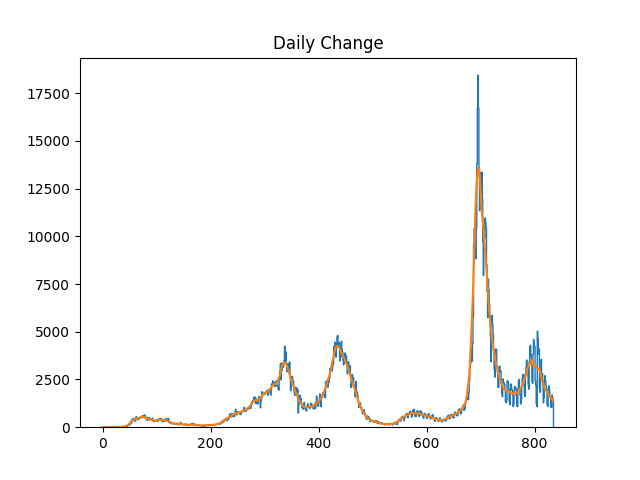

In [25]:
series = TimeSeries(data, 'confirmed')
delta_x = series.daily_change
smoothed_delta_x = analysis.estimate_slope(series, NUM_DAYS)[:,0]

plt.figure()
plt.stairs(delta_x)
plt.plot(smoothed_delta_x)
plt.title('Daily Change')
plt.show()

While it's possible to calculate $\tilde{a}[n]$ directly from $\Delta x[n]$, the
result ends up being pretty noisy due to day-to-day variations.  Using $m[n]$
produces a smoother result that better shows the overall trend.

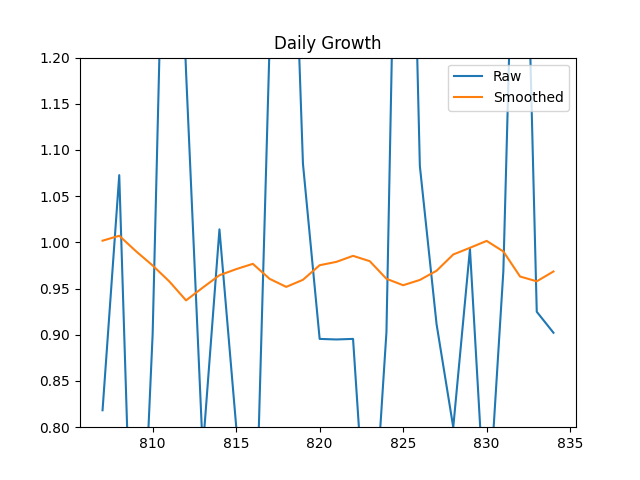

In [26]:
smoothed_daily_growth = analysis.estimate_growth(series, NUM_DAYS)

plt.figure()
rng = np.arange(len(series)-28, len(series))
plt.plot(rng, series.daily_growth[rng], label='Raw')
plt.plot(rng, smoothed_daily_growth[rng], label='Smoothed')
plt.ylim([0.8, 1.2])
plt.legend()
plt.title('Daily Growth')
plt.show()


## Predict Future Cases

Predict cases `PREDICT` days into the future using the growth factor trend as a
guide.  The predictor assumes that $\tilde{a}[n]$ is approximately linear over
short periods of time.  In other words, it's either holding steady around some
value or gradually increasing or decreasing.

In [27]:
from case_rate.analysis.predict import DailyCasesPredictor

predictor = DailyCasesPredictor(model_order=1, analysis_window=NUM_DAYS, reporting_lag=DELAY)
train_error, test_error = predictor.train(series)

print(f'Parameters:     {predictor.parameters.T}')
print(f'Training Error: {train_error}')
print(f'Test Error:     {test_error}')

Parameters:     [[0.95991503 0.00228292]]
Training Error: 0.01330416161705861
Test Error:     482.56519087710154


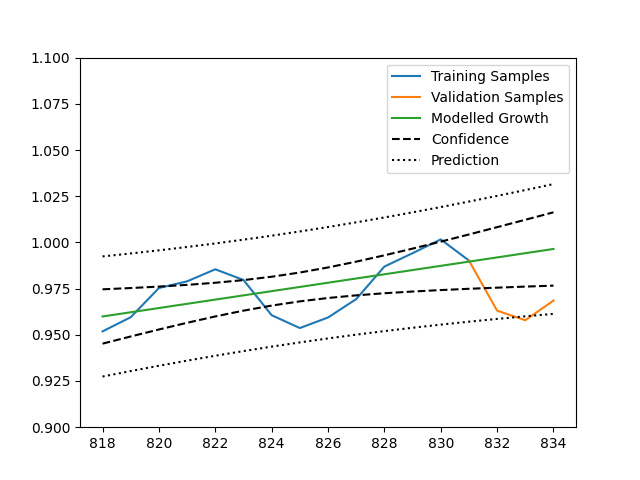

In [28]:
plt.figure()
all_samples = np.hstack((predictor.training_window, predictor.validation_window))
plt.plot(predictor.training_window, predictor.training_samples, label='Training Samples')
plt.plot(np.hstack((predictor.training_window[-1], predictor.validation_window)), 
         np.hstack((predictor.training_samples[-1], predictor.validation_samples)), 
         label='Validation Samples')
plt.plot(all_samples, predictor.growth_model(NUM_DAYS+DELAY), label='Modelled Growth')

ci = predictor.confidence_interval(NUM_DAYS+DELAY)
pi = predictor.prediction_interval(NUM_DAYS+DELAY)
plt.plot(all_samples, ci[:,0], 'k--', label='Confidence')
plt.plot(all_samples, ci[:,1], 'k--')
plt.plot(all_samples, pi[:,0], 'k:', label='Prediction')
plt.plot(all_samples, pi[:,1], 'k:')
plt.ylim((0.9, 1.1))
plt.legend()
plt.show()

The main advantage to assuming a linear trend over short time periods is that
makes it easier to reason about how the reported cases are changing and may
change in the future.  For example, if $\tilde{a}[n]$ is close to linear then
the confidence interval for the regression will be very narrow.  Conversely, it
will be wider the less linear the trend is.  The estimated $\tilde{a}[n]$ can
then be used to estimate the value of $x[n]$, $\Delta x[n]$ and $m[n]$ into the
future.

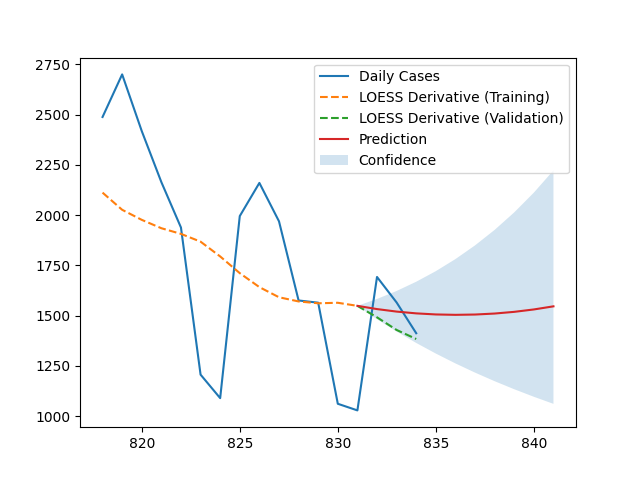

In [29]:
training_window = predictor.training_window
validation_window = np.hstack((training_window[-1], predictor.validation_window))

starting_value = smoothed_delta_x[training_window[-1]]
predicted_cases, confidence, prediction_window = predictor.predict(starting_value, PREDICT)

all_samples = np.hstack((predictor.training_window, predictor.validation_window))

plt.figure()
plt.plot(all_samples, delta_x[all_samples], label='Daily Cases')
plt.plot(training_window, smoothed_delta_x[training_window], '--', label='LOESS Derivative (Training)')
plt.plot(validation_window, smoothed_delta_x[validation_window], '--', label='LOESS Derivative (Validation)')
plt.plot(prediction_window, predicted_cases, '-', label='Prediction')
plt.fill_between(prediction_window, confidence[:, 0], confidence[:, 1], alpha=0.2, label='Confidence')
plt.legend()
plt.show()